# NBA Four Factors Analysis

Taking Justin Jacobs's idea in the [Squared 2020 Blog](https://squared2020.com/2017/09/05/introduction-to-olivers-four-factors/), this notebook deals with obtaining Four Factors data for the last 2020 regular seasons and see how important each of them were over the years. First, a little introduction.

## Four Factors

The term is based on what Dean Oliver called the *Four Factors of Basketball Success*, which are:

- Shooting
- Turnovers
- Rebounding
- Free Throws

These are important for any team both on offense and defense, and for that reason we can think that we have 8 factors instead of 4 and they can be obtained from just the box scores. I will explain them a bit more in detail below.

### Shooting
As we all now, the team that gets more points wins basketball games. This factor is measured as the *Effective Field Goal Percentage* (EFG%):

$$
EFG\% = \frac{FGM + 0.5 FG3M}{FGA},
$$

where
- FGM: Field Goals Made
- FG3M: 3-Point Shots Made
- FGA: Field Goal Attempts

### Turnovers
Teams need to take care of the ball to get the best out of their possessions. This factor is measured with the *Turnover Percentage* (TOV%):

$$
TOV\% = \frac{TOV}{POSS},
$$

where
- TOV: Turnovers
- POSS: Amount of Possessions in the Season

### Rebounding
An offensive rebound is another way of making the best of our possessions in case we don't shoot the ball well, taking second (or more) chances to score. The offensive rebounding factor is the *Offensive Rebound Percentage* (ORB%):

$$
ORB\% = \frac{ORB}{ORB + OppDRB},
$$

where
- ORB: Offensive Rebounds
- OppDRB. Opponents's Defensive Rebounds

For the defensive rebounding factor, we can get the ORB% for the opponents (OppORB%, this is the one available in the NBA Stats Page) or the *Defensive Rebounding Percentage* (DRB%):

$$
DRB\% = \frac{DRB}{DRB + OppORB},
$$

where
- DRB: Defensive Rebounds
- OppORB. Opponents's Offensive Rebounds

### Free Throws
Lastly, one of the ways we can end a possession is by getting to the free throw line (except when getting shots because of technical or flagrant fouls). This is the relationship between the amount of free throws a team attempted (FTA) and the field goals attempted (FGA), the *Free Throw Rate* (FTRATE):

$$
FTRATE = \frac{FTA}{FGA}
$$

## Computing NBA Four Factors Importance
Luckily, the NBA Stats Page has these factors already computed for a lot of seaons for us to use, so we will use it to get the Four Factors for the last 20 seasons and get the importance of each of them over the years, by adjusting a linear model and try to predict the winning percentage of the teams. In this case, winning percentage might be better than amount of wins, since we had a couple of seasons with a weird number of games played (thanks to some virus).

### Data Obtention

In [122]:
# Imports
from nba_api.stats.endpoints import leaguedashteamstats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import time

Let's start by getting the Four Factors data for the 20 seasons in one DataFrame.

In [123]:
four_factors = pd.DataFrame()
for i in range(20):
    # Building the Season String (ie. 2020-21)
    season_str = f"{2001 + i}-{2 + i:02d}"
    # Let's make some attempts to obtain the data, since we might be doing too many requests...
    for attempt in range(5):
        try:
            season_factors = leaguedashteamstats.LeagueDashTeamStats(
                season=season_str, measure_type_detailed_defense="Four Factors",
            ).get_data_frames()[0]
            season_factors["season"] = 2002 + i
            # Try to get the information for the season, getting only the columns we need
            four_factors = pd.concat(
                [four_factors, season_factors],
                axis=0,
            )
        except:
            # If we get an error we go to sleep for some time
            time.sleep(30)
        else:
            # If everything's OK with the request, we continue
            break

In [130]:
# Get a random sample
four_factors.sample(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,CFID,CFPARAMS,season
12,1610612763,Memphis Grizzlies,82,28,54,0.341,3986.0,0.487,0.287,0.162,...,18,19,21,28,3,18,29,10,Memphis Grizzlies,2003
9,1610612745,Houston Rockets,82,34,48,0.415,3966.0,0.471,0.317,0.162,...,22,23,22,6,16,26,8,10,Houston Rockets,2006
10,1610612754,Indiana Pacers,82,44,38,0.537,3981.0,0.476,0.358,0.160,...,4,21,28,7,23,17,10,10,Indiana Pacers,2005
13,1610612747,Los Angeles Lakers,82,37,45,0.451,3956.0,0.527,0.257,0.150,...,16,28,14,11,7,16,19,10,Los Angeles Lakers,2019
28,1610612762,Utah Jazz,82,41,41,0.500,3976.0,0.467,0.397,0.174,...,2,28,1,14,30,11,10,10,Utah Jazz,2006


### Adjusting our Linear Models
For each season, we will adjust a linear model without intercept (using Scikit Learn) that depends on our 8 factors to the **Win Percentage (W%)** of each team. We will just focus on the offensive factors' importance then, and we will store that data in a new DataFrame.

In [125]:
four_factors_models = pd.DataFrame(columns=["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT"])
for i in range(20):
    # For each season, we will fit a linear model, trying to adjust it to the win percentage
    season = 2002 + i
    season_factors = four_factors.loc[
        four_factors["season"] == season,
        ["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT", "OPP_EFG_PCT", "OPP_FTA_RATE", "OPP_TOV_PCT", "OPP_OREB_PCT"],
    ]
    model = LinearRegression(fit_intercept=False)
    model.fit(
        X=season_factors,
        y=four_factors.loc[four_factors["season"] == season, "W_PCT"],
    )
    season = 2002 + i
    # Put the 4 first factors (offensive)
    four_factors_models.loc[season] = np.abs(model.coef_[:4]) / np.sum(np.abs(model.coef_[:4]))


In [126]:
four_factors_models.head()

,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT
2002,0.408893,0.063766,0.409220,0.118122
2003,0.518899,0.040976,0.307262,0.132864
2004,0.432751,0.048626,0.317373,0.201250
2005,0.445683,0.046723,0.340023,0.167571
2006,0.414419,0.042803,0.310623,0.232155


### Plot and Analysis

We can represent the relative importance of each factor as years go on as a stacked box plot, since our factor importance sums 1 for every year.

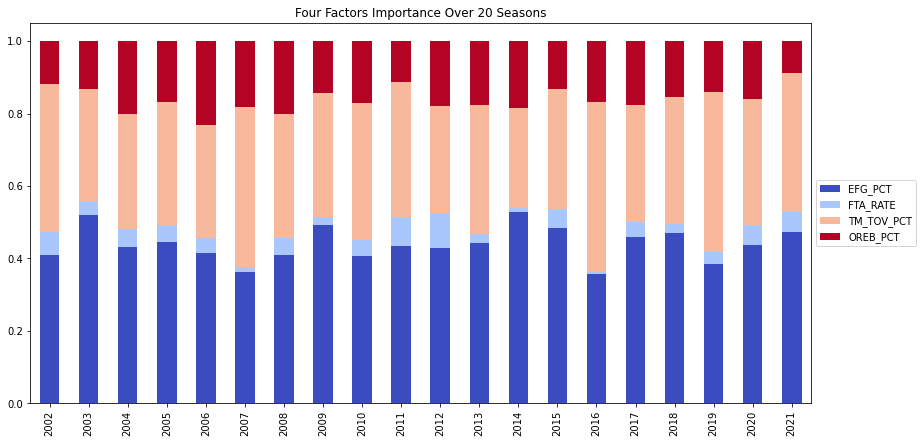

In [128]:
four_factors_models.plot.bar(
    stacked=True, cmap="coolwarm",
    figsize=(14, 7),
    title="Four Factors Importance Over 20 Seasons",
).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In the past, Dean Oliver assigned the following importance to the offensive factors:

- Shooting (40%)
- Turnovers (25%)
- Rebounding (20%)
- Free Throws (15%)

Let's see which of these 20 years is closer to that distribution according to our models (using Euclidean distance).

In [134]:
# Get the argument for the closest row to the distribution above.
argmin = np.argmin(np.linalg.norm((four_factors_models - np.array([0.4, 0.15, 0.25, 0.20])), axis=1))
# Show the Series corresponding to that argument.
four_factors_models.iloc[argmin]

EFG_PCT       0.429392
FTA_RATE      0.095517
TM_TOV_PCT    0.295126
OREB_PCT      0.179964
Name: 2012, dtype: float64

As we can see, the closest season to that distribution was the **2011-12** Season, where we experienced the last lockout, and [Chris Paul was held hostage by the NBA](https://www.nytimes.com/2011/12/10/sports/basketball/nba-basketball-roundup.html?_r=1&ref=basketball&pagewanted=all).

The Heat (with Lebron, Wade and Bosh) won the championship after defeating the Durant, Westbrook and Harden led Thunder. This season had 66 games and is the one where FTRATE was at its max.

The Four Factors can give us a good estimation of what it takes to win NBA games, and can be useful for teams to figure out what they may be lacking, in order to get in the best shape for the next season. Thanks to the NBA Stats API we can put all this data into a DataFrame and get even more insights. For example, now we know that taking care of the ball is really important for teams, we can figure out which were the 5 worse ones on that aspect last season.

In [140]:
four_factors.loc[four_factors["season"] == 2021].sort_values(by="TM_TOV_PCT", ascending=False)[["TEAM_NAME", "TM_TOV_PCT"]].head(5)

,TEAM_NAME,TM_TOV_PCT
20,Oklahoma City Thunder,0.158
5,Cleveland Cavaliers,0.157
13,Los Angeles Lakers,0.152
4,Chicago Bulls,0.151
8,Detroit Pistons,0.151


Maybe this is the reason why the [Lakers are desperately looking for a Point Guard](https://247sports.com/Article/Los-Angeles-Lakers-trade-free-agency-All-Star-point-guard-Chris-Paul-Russell-Westbrook-168220327/) for next season!